In [2]:
import os
import mne
import mne_bids
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from mne_bids import BIDSPath, find_matching_paths, make_report, print_dir_tree, read_raw_bids

In [3]:
print('MNE–Python version', mne.__version__)
print('MNE–BIDS version', mne_bids.__version__)

MNE–Python version 1.8.0
MNE–BIDS version 0.16.0


### define inputs

In [4]:
# on Mac Studio Sharepoint
bids_root = os.path.join('/Users/dsj3886/',
                         'Library/CloudStorage/',
                         'OneDrive-NorthwesternUniversity',
                         'Documents - SoundBrain Lab',
                         'Lab Research Projects/',
                         'Experiments/NU_Experiments/',
                         'EAM1/', 'data-bids')
# on Mac Studio local
#bids_root = os.path.join('/Users/dsj3886/data_local/',
#                        'EAM1_local/data-bids')

# on MBA
#bids_root = os.path.join('/Users/dsj3886/data_local/',
#                        'EAM1/data-bids')

print_dir_tree(bids_root)

|data-bids/
|--- .DS_Store
|--- README
|--- dataset_description.json
|--- participants.json
|--- participants.tsv
|--- derivatives/
|------ sub-15_task-active_run-all_epochs.fif
|------ sub-15_task-passive_run-all_epochs.fif
|--- sub-02/
|------ sub-02_scans.tsv
|------ eeg/
|--------- sub-02_task-active_run-1_channels.tsv
|--------- sub-02_task-active_run-1_eeg.bdf
|--------- sub-02_task-active_run-1_eeg.json
|--------- sub-02_task-active_run-1_events.json
|--------- sub-02_task-active_run-1_events.tsv
|--------- sub-02_task-active_run-2_channels.tsv
|--------- sub-02_task-active_run-2_eeg.bdf
|--------- sub-02_task-active_run-2_eeg.json
|--------- sub-02_task-active_run-2_events.json
|--------- sub-02_task-active_run-2_events.tsv
|--------- sub-02_task-passive_run-1_channels.tsv
|--------- sub-02_task-passive_run-1_eeg.bdf
|--------- sub-02_task-passive_run-1_eeg.json
|--------- sub-02_task-passive_run-1_events.json
|--------- sub-02_task-passive_run-1_events.tsv
|--------- sub-02_ta

In [5]:
# outputs
deriv_dir = os.path.join(bids_root, 'derivatives')



# Combine multiple runs (BIDS)

In [6]:
sub_label = '15'
task_list = ['active', 'passive']

In [7]:
# define function to generate event labels and codes
# (differs per participant)
# TODO: add motor condition
# TODO: fix sub < 13 task-active codes
def generate_event_dict(sub_label, task_label):
    if int(sub_label) > 19:
        event_dict = {'passive/pos': 1,
                    'passive/neg': 2,
                    'active/pos': 3,
                    'active/neg': 4}
    elif int(sub_label) > 13:
        event_dict = {f'{task_label}/pos': 1,
                    f'{task_label}/neg': 2,}
    elif int(sub_label) < 13:
        if task_label == 'passive':
            event_dict = {f'{task_label}/pos': 2049,
                        f'{task_label}/neg': 2050,}
        elif task_label == 'active':
            print('all active coded as 2049.',
                  '  need to fix')
            event_dict = {f'{task_label}/pos': 2049,
                        f'{task_label}/neg': 2050,}
            #pass
    return event_dict

In [8]:
# define event labels and codes (differs per participant)
if int(sub_label) > 19:
    event_dict = {'passive/pos': 1,
                 'passive/neg': 2,
                 'active/pos': 3,
                 'active/neg': 4}
    event_mapping = {1:'passive/pos',
                     2:'passive/neg',
                     3:'active/pos',
                    4:'active/neg'}
elif int(sub_label) > 13:
    event_dict = {'pos': 1,
                  'neg': 2,}
    event_mapping = {1:'pos',
                     2:'neg'}
elif int(sub_label) < 13:
    print('all active coded as 2049.',
         '  need to fix')
    #event_dict = {'pos': 2049,
    #              'neg': 2050,}

In [ ]:
for sub_num in range(14, 35):
    sub_label = f'{sub_num:02d}'
    if int(sub_label) > 19:
        event_mapping = {1:'passive/pos',
                        2:'passive/neg',
                        3:'active/pos',
                        4:'active/neg'}
    elif int(sub_label) > 13:
        event_mapping = {1:'pos',
                         2:'neg'}
    else:
        event_mapping = {2049:'pos',
                         2050:'neg'}

    # initialize an empty dictionary for data
    task_evoked_dict = {}
    event_evoked_dict = {}

    for task_label in task_list:
        print(f'Loading {task_label} data')

        epoch_list = []

        for run_label in range(1,6):
        # load in EEG data
            bids_path = BIDSPath(root=bids_root, datatype='eeg', subject=str(sub_label), task=task_label, run=run_label)
            
            try:
                data = read_raw_bids(bids_path)
                data.load_data()

                # re-reference data to linked mastoid reference
                data_ref = data.set_eeg_reference(ref_channels=['M1', 'M2'])
                
                # filter data
                data_filtered = data_ref.copy().filter(l_freq=65, h_freq=2000)
                
                # find events
                events = mne.find_events(data_filtered, 
                                        stim_channel='Status', 
                                        initial_event=True)
                
                # testing creating events from annotations
                # events_from_annot, event_dict2 = mne.events_from_annotations(data_filtered)

                # that didn't work - how about annotations from the events
                annot_from_events = mne.annotations_from_events(
                                                                events=events,
                                                                event_desc=event_mapping,
                                                                sfreq=data_filtered.info['sfreq'])
                
                # epoch data based on stimulus events
                epochs = mne.Epochs(data_filtered, 
                                    #events=events_from_annot, #events, 
                                    #event_id=event_dict2, #event_dict,
                                    on_missing='warn',
                                    picks=['Cz'],
                                    tmin=-0.04, tmax=0.5, 
                                    baseline=[-0.04, 0],
                                    reject=dict(eeg=75e-6)).drop_bad()
                
                epoch_list.append(epochs)

            except:
                print(f"No run {run_label} for task-{task_label}")
        
        # combine epochs across runs
        all_epochs = mne.concatenate_epochs(epoch_list)

        out_base = f'sub-{sub_label}_task-{task_label}_run-all_epochs.fif'
        epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)

        '''
        # create evoked average from across-run epochs
        event_evoked = all_epochs.average(by_event_type=True)
        all_evoked = all_epochs.average()

        # add to results dict
        event_evoked_dict[task_label] = event_evoked
        task_evoked_dict[task_label] = all_evoked
        '''

In [11]:
event_dict

{'pos': 1, 'neg': 2}

### load epochs

In [22]:
active_epochs = sorted(glob(deriv_dir+'/sub-*_task-active_run-all_epochs.fif'))
passive_epochs = sorted(glob(deriv_dir+'/sub-*_task-passive_run-all_epochs.fif'))

In [23]:
sub_active_epochs = mne.read_epochs(active_epochs[0])
sub_active_evoked = sub_active_epochs.average()

sub_passive_epochs = mne.read_epochs(passive_epochs[0])
sub_passive_evoked = sub_passive_epochs.average()

Reading /Users/dsj3886/Library/CloudStorage/OneDrive-NorthwesternUniversity/Documents - SoundBrain Lab/Lab Research Projects/Experiments/NU_Experiments/EAM1/data-bids/derivatives/sub-02_task-active_run-all_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -39.98 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1118 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/dsj3886/Library/CloudStorage/OneDrive-NorthwesternUniversity/Documents - SoundBrain Lab/Lab Research Projects/Experiments/NU_Experiments/EAM1/data-bids/derivatives/sub-02_task-passive_run-all_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =     -39.98 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1185 matching events found
No baseline correction applied
0 projection items activated


/var/folders/5c/_fg_mvnx2dv1jhkw5xg5fv1h0000gq/T/ipykernel_51141/1073512979.py:1: RuntimeWarning: This filename (/Users/dsj3886/Library/CloudStorage/OneDrive-NorthwesternUniversity/Documents - SoundBrain Lab/Lab Research Projects/Experiments/NU_Experiments/EAM1/data-bids/derivatives/sub-02_task-active_run-all_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_active_epochs = mne.read_epochs(active_epochs[0])
/var/folders/5c/_fg_mvnx2dv1jhkw5xg5fv1h0000gq/T/ipykernel_51141/1073512979.py:4: RuntimeWarning: This filename (/Users/dsj3886/Library/CloudStorage/OneDrive-NorthwesternUniversity/Documents - SoundBrain Lab/Lab Research Projects/Experiments/NU_Experiments/EAM1/data-bids/derivatives/sub-02_task-passive_run-all_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  sub_passive_epochs = mne.read_epochs(passive_ep

Need more than one channel to make topography for eeg. Disabling interactivity.


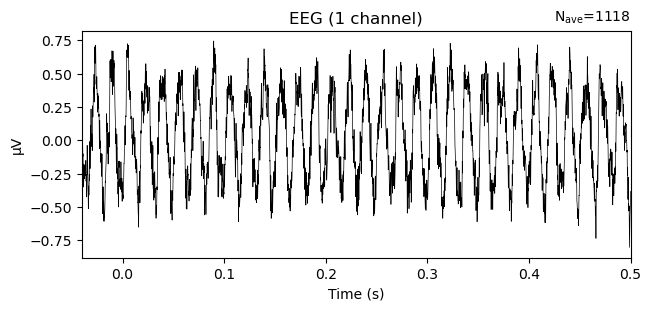

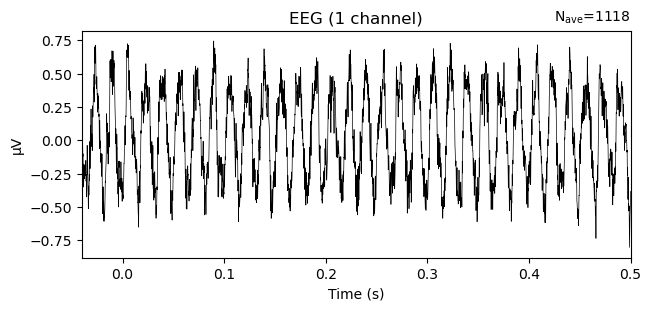

In [20]:
sub_active_evoked.plot()

Need more than one channel to make topography for eeg. Disabling interactivity.


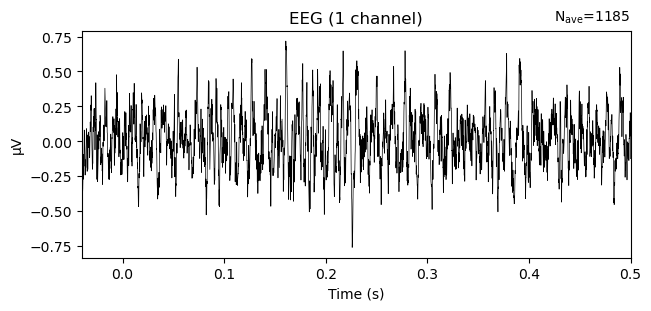

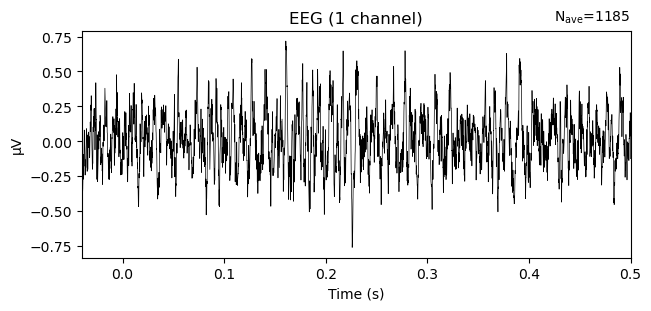

In [24]:
sub_passive_evoked.plot()

### Plot individual polarities

In [94]:
event_evoked_dict

{'active': [<Evoked | 'passive/pos' (average, N=0), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~63 KiB>,
  <Evoked | 'passive/neg' (average, N=0), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~63 KiB>,
  <Evoked | 'active/pos' (average, N=1744), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~63 KiB>,
  <Evoked | 'active/neg' (average, N=1751), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~63 KiB>],
 'passive': [<Evoked | 'passive/pos' (average, N=1376), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~63 KiB>,
  <Evoked | 'passive/neg' (average, N=1354), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~63 KiB>,
  <Evoked | 'active/pos' (average, N=0), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~63 KiB>,
  <Evoked | 'active/neg' (average, N=0), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~63 KiB>]}

In [95]:
# Waveforms
fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
event_evoked_dict['passive'][0].plot(axes=ax[0], selectable=False, show=False)
event_evoked_dict['passive'][1].plot(axes=ax[1], selectable=False, show=False)
event_evoked_dict['active'][0].plot(axes=ax[2], selectable=False, show=False)
event_evoked_dict['active'][1].plot(axes=ax[3], selectable=False, show=False)

ax[0].set_title('passive ' + event_evoked_dict['passive'][0].comment);
ax[1].set_title('passive ' + event_evoked_dict['passive'][1].comment);
ax[2].set_title('active ' + event_evoked_dict['active'][0].comment);
ax[3].set_title('active ' + event_evoked_dict['active'][1].comment);

fig.suptitle(f'sub-{sub_label} FFR timeseries')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_timeseries.svg')

ValueError: Some of the values  to be plotted are NaN.

    Using multitaper spectrum estimation with 7 DPSS windows


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


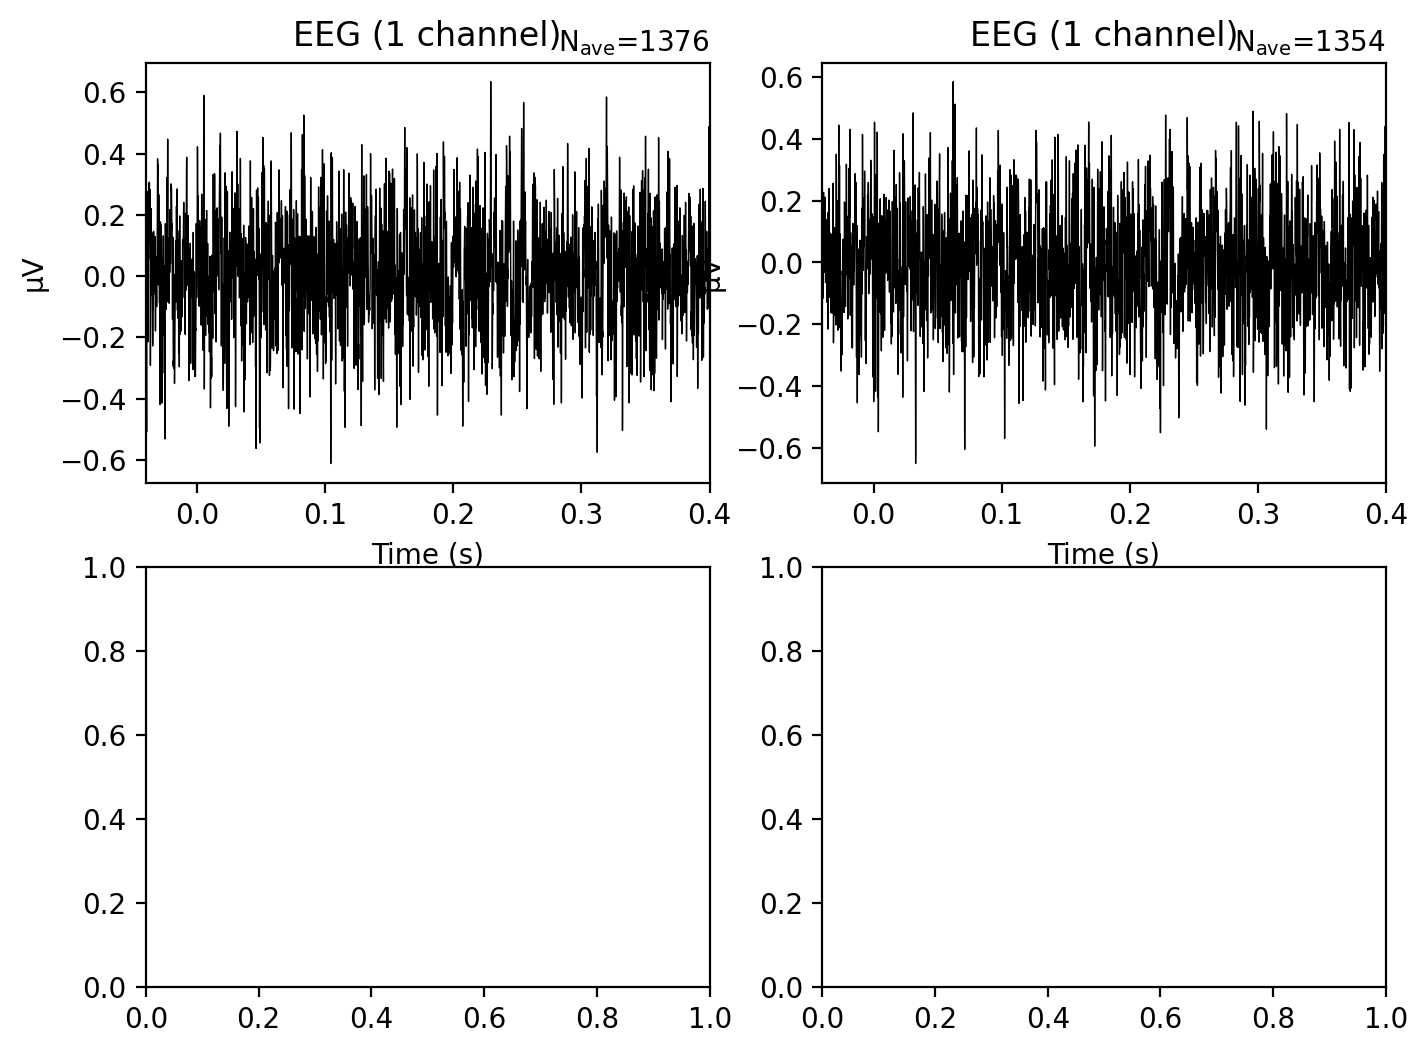

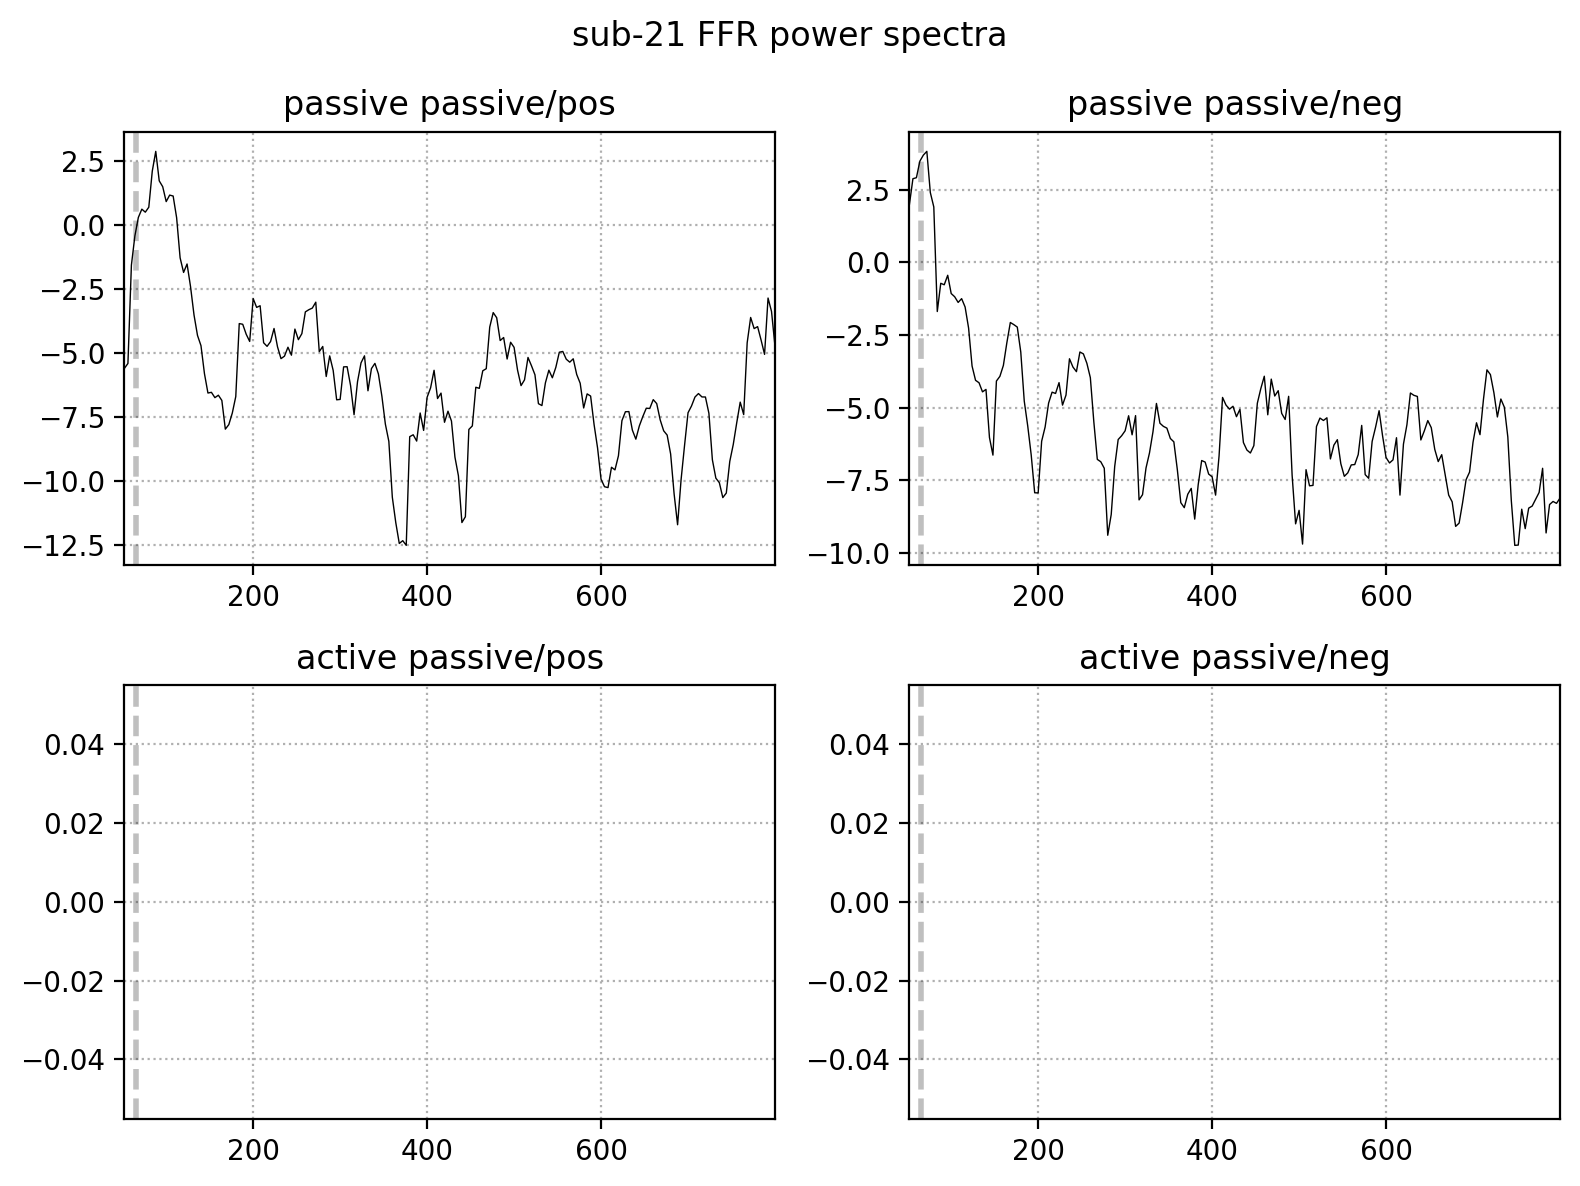

In [96]:
# Power spectra
passive_pos_psd = event_evoked_dict['passive'][0].compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
passive_neg_psd = event_evoked_dict['passive'][1].compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
active_pos_psd = event_evoked_dict['active'][0].compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
active_neg_psd = event_evoked_dict['active'][1].compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)

fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
passive_pos_psd.plot(axes=ax[0], amplitude=False, average=True, show=False)
passive_neg_psd.plot(axes=ax[1], amplitude=False, average=True, show=False)
active_pos_psd.plot(axes=ax[2], amplitude=False, average=True, show=False)
active_neg_psd.plot(axes=ax[3], amplitude=False, average=True, show=False)

ax[0].set_title('passive ' + event_evoked_dict['passive'][0].comment);
ax[1].set_title('passive ' + event_evoked_dict['passive'][1].comment);
ax[2].set_title('active ' + event_evoked_dict['active'][0].comment);
ax[3].set_title('active ' + event_evoked_dict['active'][1].comment);

fig.suptitle(f'sub-{sub_label} FFR power spectra')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectra.svg')

No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


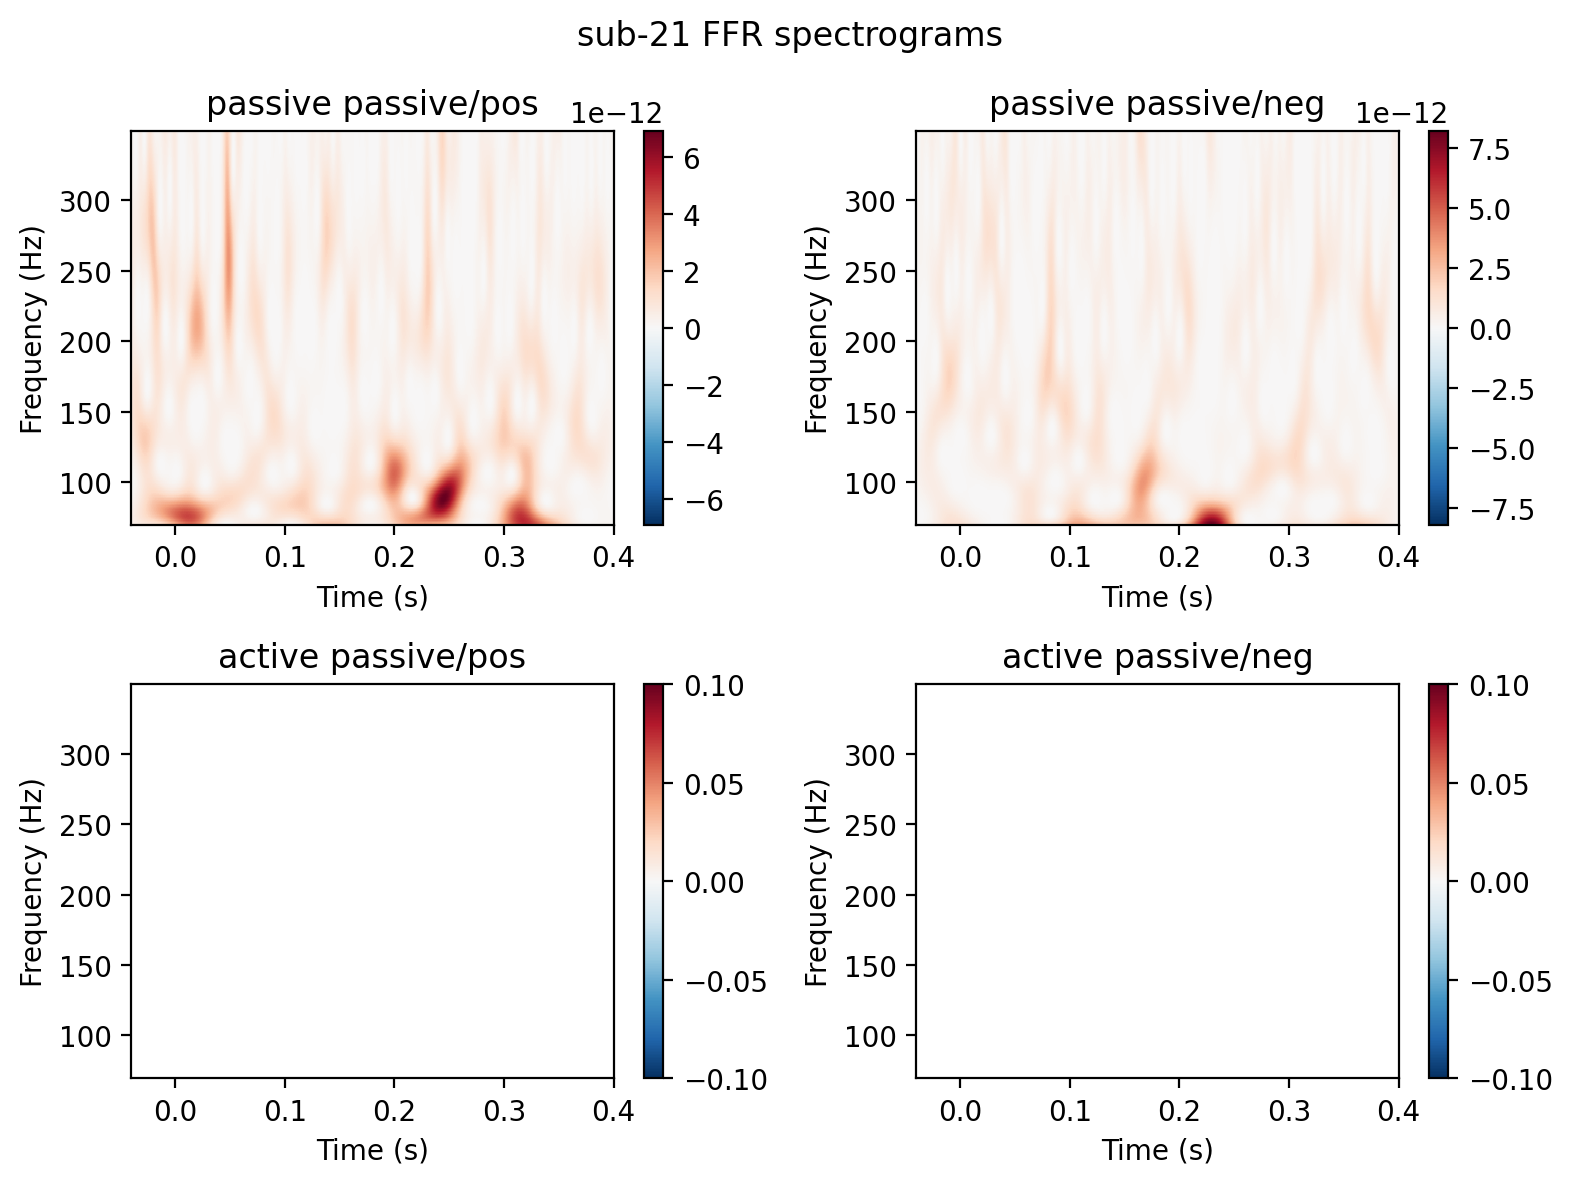

In [97]:
# Spectrograms
frequencies = np.arange(70,350)

passive_pos_power = event_evoked_dict['passive'][0].compute_tfr("morlet", freqs=frequencies)
passive_neg_power = event_evoked_dict['passive'][1].compute_tfr("morlet", freqs=frequencies)
active_pos_power = event_evoked_dict['active'][0].compute_tfr("morlet", freqs=frequencies)
active_neg_power = event_evoked_dict['active'][1].compute_tfr("morlet", freqs=frequencies)

fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
passive_pos_power.plot(axes=ax[0], show=False)
passive_neg_power.plot(axes=ax[1], show=False)
active_pos_power.plot(axes=ax[2], show=False)
active_neg_power.plot(axes=ax[3], show=False)

ax[0].set_title('passive ' + event_evoked_dict['passive'][0].comment);
ax[1].set_title('passive ' + event_evoked_dict['passive'][1].comment);
ax[2].set_title('active ' + event_evoked_dict['active'][0].comment);
ax[3].set_title('active ' + event_evoked_dict['active'][1].comment);

fig.suptitle(f'sub-{sub_label} FFR spectrograms')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectrograms.svg')

### Plot combined polarities

In [98]:
task_evoked_dict

{'active': <Evoked | '0.00 × passive/pos + 0.00 × passive/neg + 0.50 × active/pos + 0.50 × active/neg' (average, N=3495), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~63 KiB>,
 'passive': <Evoked | '0.50 × passive/pos + 0.50 × passive/neg + 0.00 × active/pos + 0.00 × active/neg' (average, N=2730), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~63 KiB>}

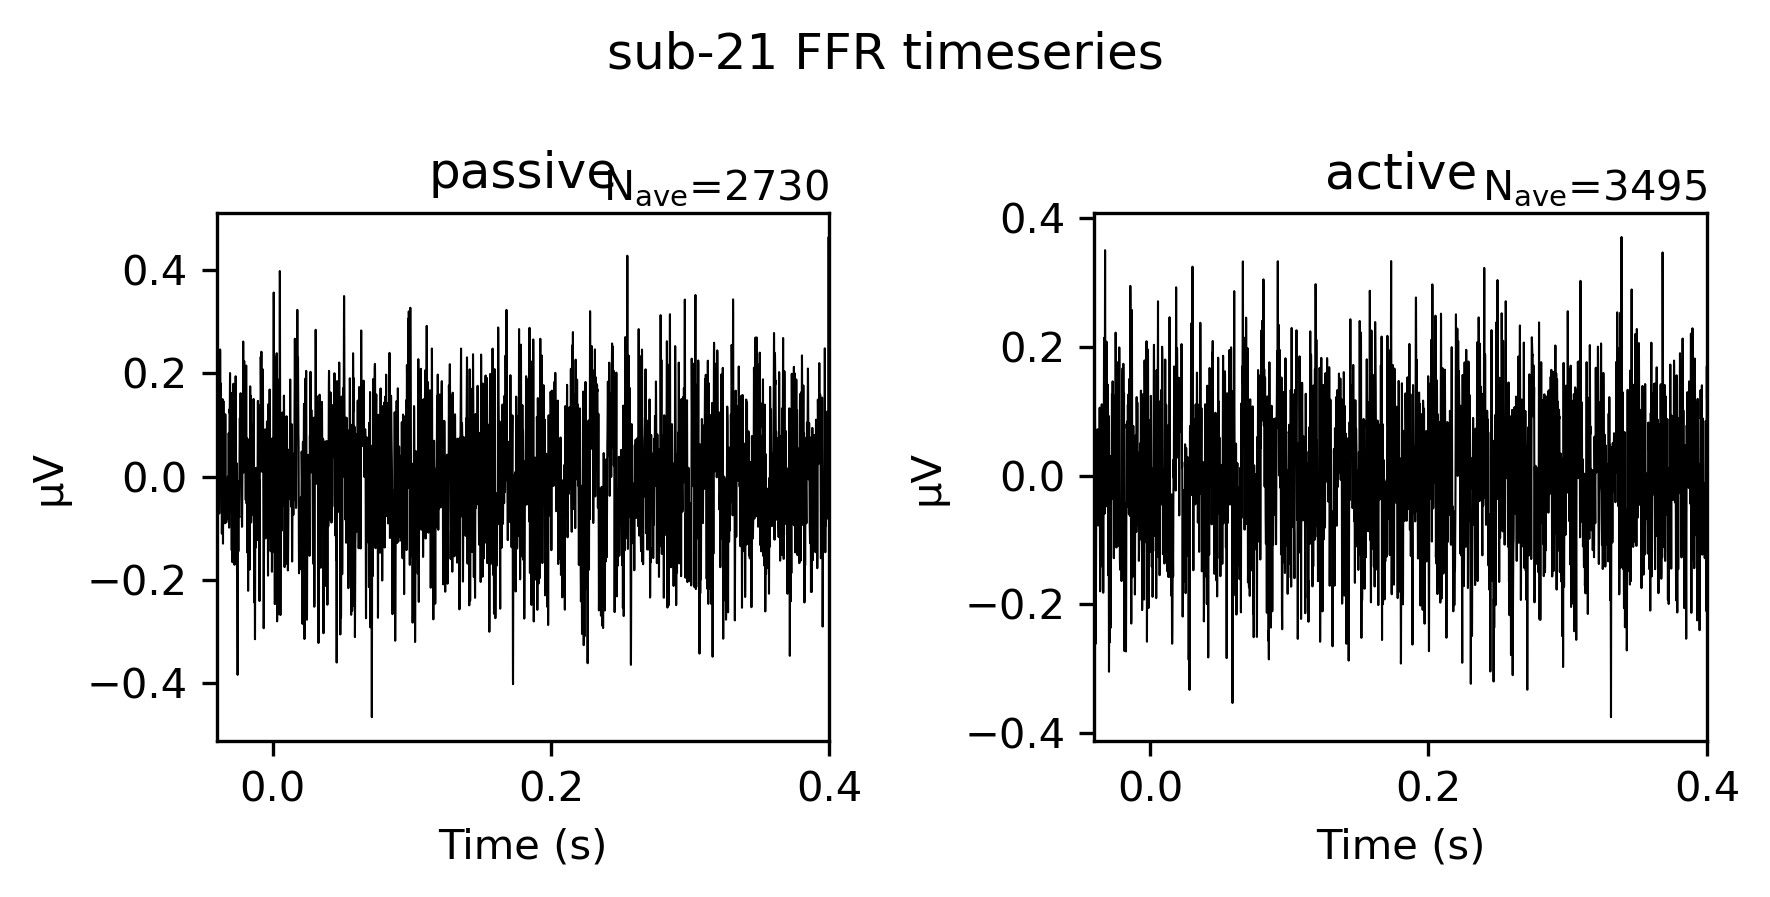

In [99]:
# Waveforms
fig, ax = plt.subplots(1, 2, figsize=(6,3), dpi=300)
task_evoked_dict['passive'].plot(axes=ax[0], selectable=False, show=False)
task_evoked_dict['active'].plot(axes=ax[1], selectable=False, show=False)

ax[0].set_title('passive');
ax[1].set_title('active');

fig.suptitle(f'sub-{sub_label} FFR timeseries')

fig.tight_layout()
plt.show()
plt.savefig(f'sub-{sub_label}_timeseries.svg')

    Using multitaper spectrum estimation with 7 DPSS windows


    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


<Figure size 640x480 with 0 Axes>

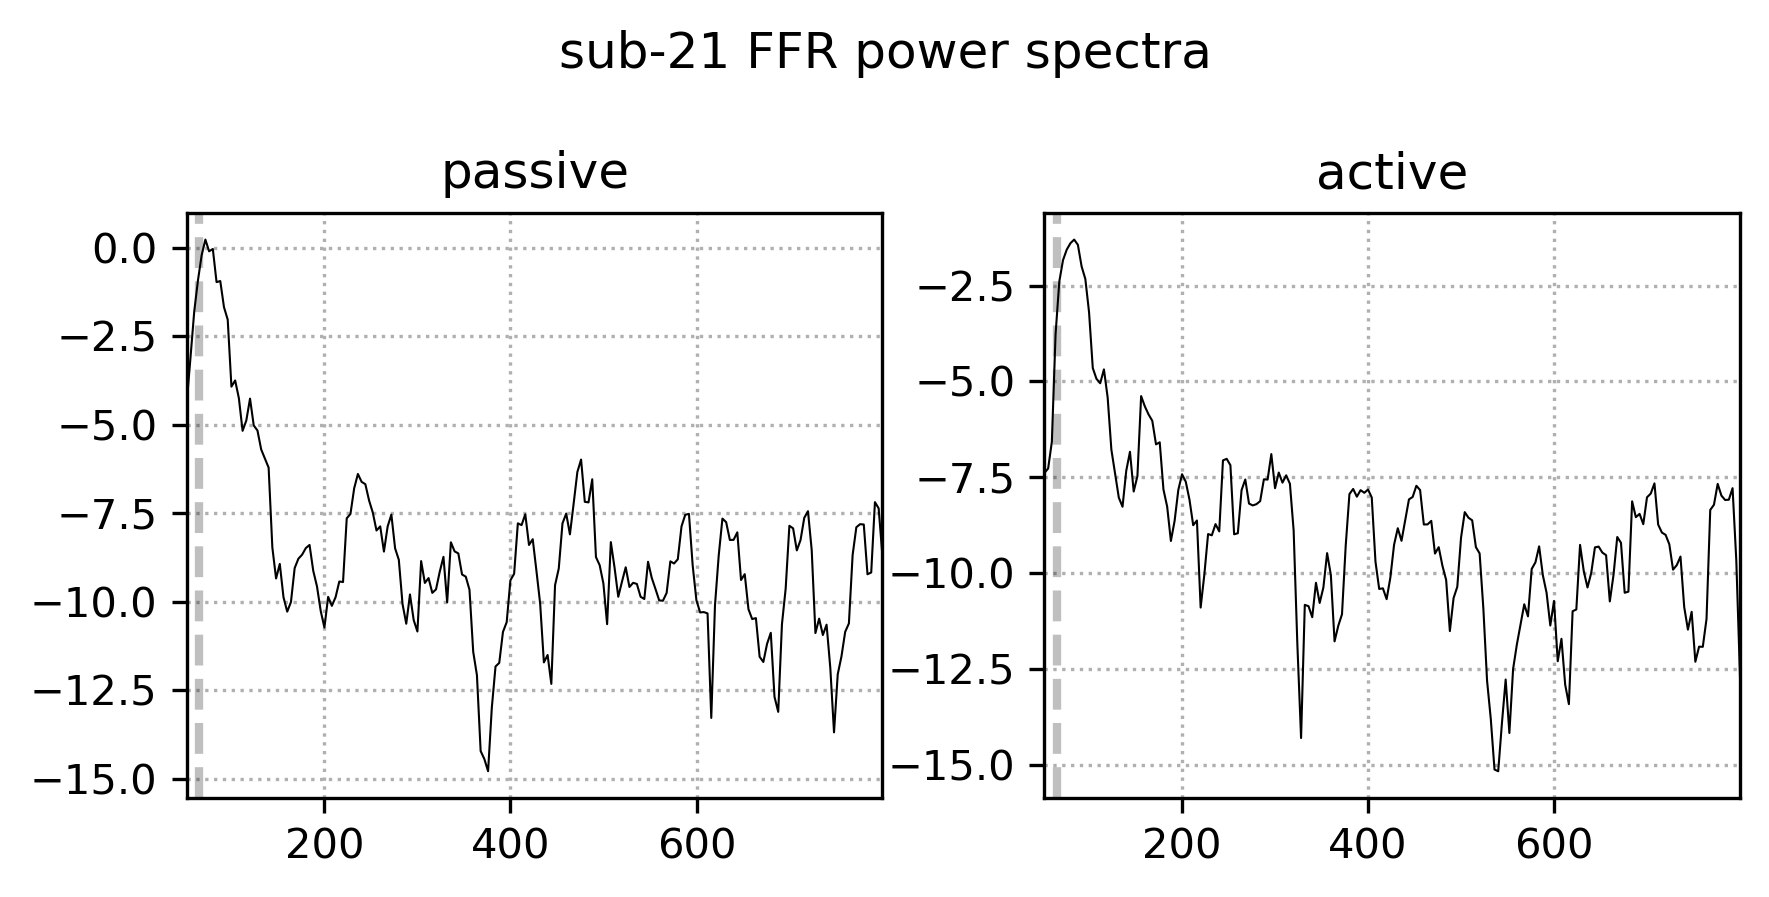

In [100]:
# Power spectra
passive_psd = task_evoked_dict['passive'].compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
active_psd = task_evoked_dict['active'].compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
fig, ax = plt.subplots(1, 2, figsize=(6,3), dpi=300)
passive_psd.plot(axes=ax[0], amplitude=False, average=True, show=False)
active_psd.plot(axes=ax[1], amplitude=False, average=True, show=False)

ax[0].set_title('passive');
ax[1].set_title('active');

fig.suptitle(f'sub-{sub_label} FFR power spectra')

fig.tight_layout()
plt.show()
plt.savefig(f'sub-{sub_label}_spectra.svg')

No baseline correction applied
No baseline correction applied


<Figure size 640x480 with 0 Axes>

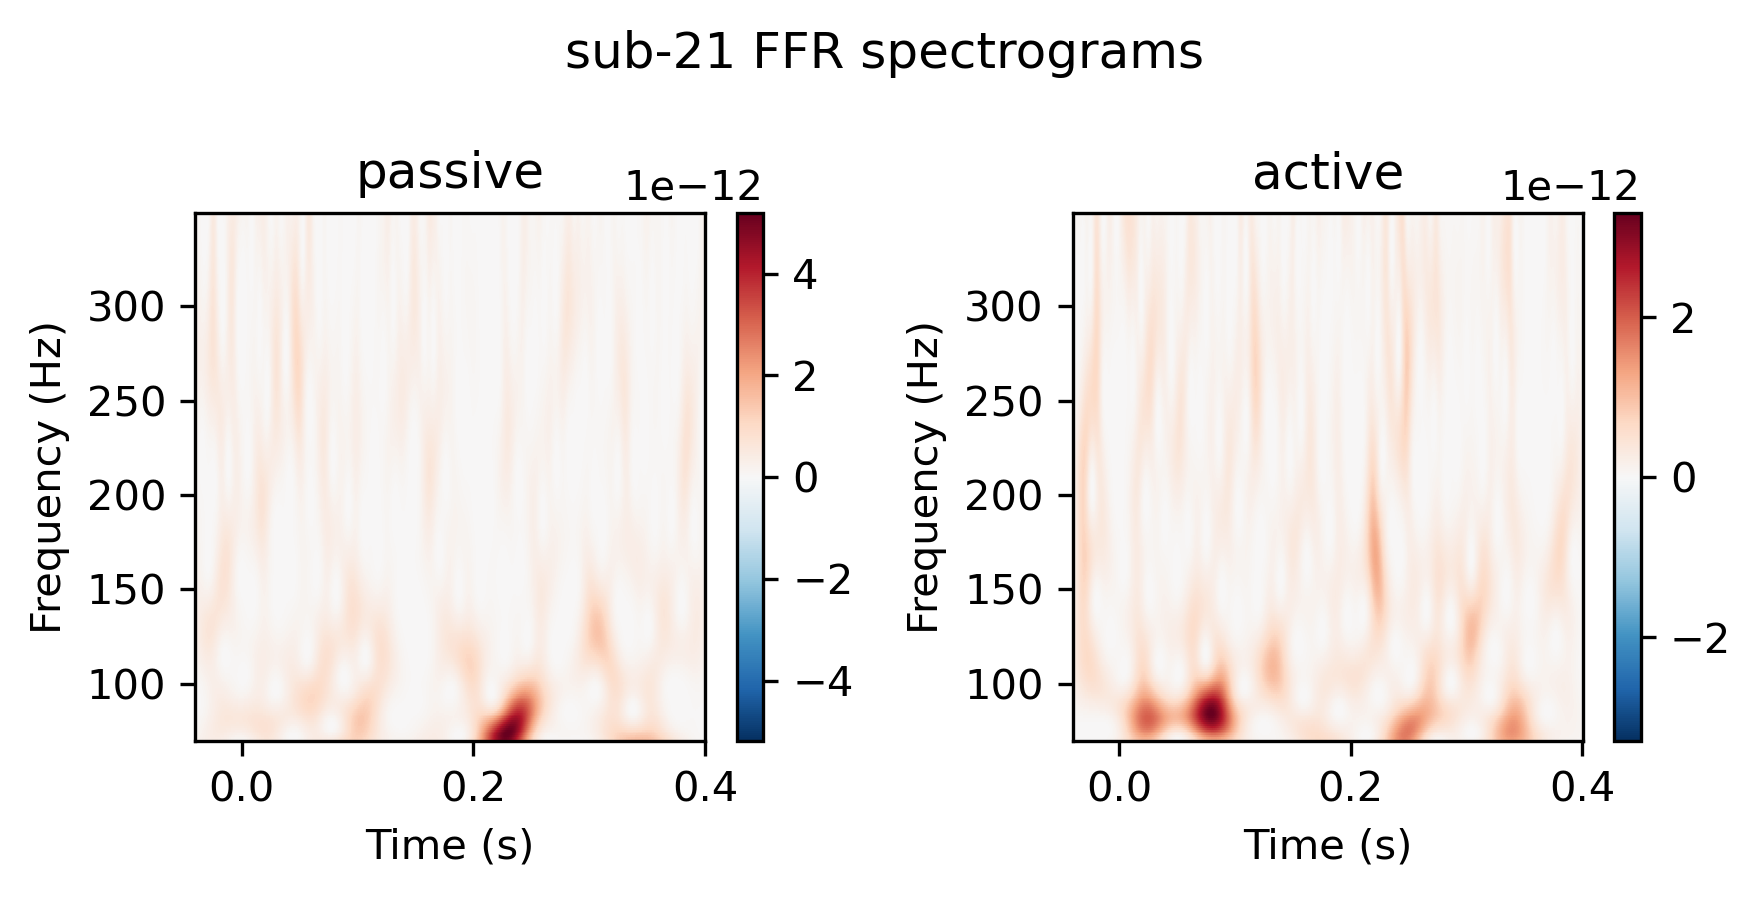

In [101]:
# Spectrograms
frequencies = np.arange(70,350)
active_power =  task_evoked_dict['active'].compute_tfr("morlet", freqs=frequencies)
passive_power =  task_evoked_dict['passive'].compute_tfr("morlet", freqs=frequencies)
fig, ax = plt.subplots(1, 2, figsize=(6,3), dpi=300)
passive_power.plot(axes=ax[0], show=False)
active_power.plot(axes=ax[1], show=False)

ax[0].set_title('passive');
ax[1].set_title('active');

fig.suptitle(f'sub-{sub_label} FFR spectrograms')

fig.tight_layout()
plt.show()
plt.savefig(f'sub-{sub_label}_spectrograms.svg')

# QA and metrics

## RMS SNR

In [76]:
from numpy import mean, sqrt, square, arange

In [78]:
for sx, stim in enumerate(task_evoked_dict):
    s_evoked = task_evoked_dict[stim]
    baseline_ind_bounds = s_evoked.time_as_index(task_evoked_dict[stim].baseline)
    response_ind_bounds = s_evoked.time_as_index([0.05, 0.200])

    evoked_baseline = s_evoked.data[0,baseline_ind_bounds[0]:baseline_ind_bounds[1]]
    evoked_response = s_evoked.data[0,response_ind_bounds[0]:response_ind_bounds[1]]
    rms_baseline = sqrt(mean(square(evoked_baseline)))
    rms_response = sqrt(mean(square(evoked_response)))

    rms_snr = rms_response / rms_baseline

    print(f'{stim} RMS SNR: {rms_snr:.04f}')
print(f'\nMean RMS SNR: {rms_snr.mean():.04f}' )

active RMS SNR: 0.9412
passive RMS SNR: 1.5903
motor RMS SNR: 0.8907

Mean RMS SNR: 0.8907


## [IN PREP] Autocorrelation

In [42]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [43]:
acf, confint = sm.tsa.stattools.acf(all_evoked.data[0,:], 
                                    nlags=len(all_evoked.data[0,:])-1,
                                    alpha=.05)

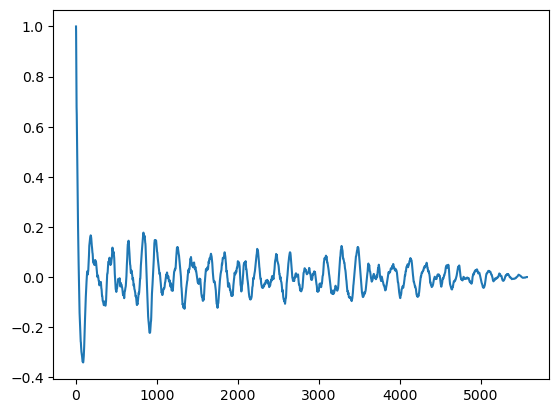

In [44]:
plt.plot(acf)
plt.show()

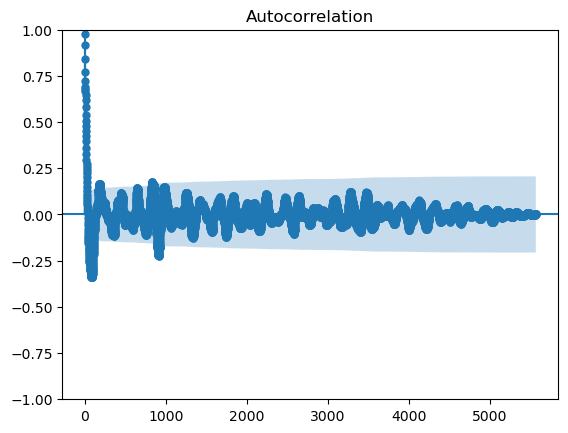

In [45]:
sm.graphics.tsa.plot_acf(all_evoked.data[0,:], 
                         lags=len(all_evoked.data[0,:])-1, 
                         zero=False,)

## [IN PREP] Stimulus–response correlations


In [46]:
data.pick(['Erg1'])

Measurement date,"July 18, 2024 13:12:19 GMT"
Experimenter,Unknown
Participant,
Digitized points,Not available
Good channels,1 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,16384.00 Hz
Highpass,0.00 Hz
Lowpass,3334.00 Hz


In [47]:
# epoch data based on stimulus events
stim_epochs = mne.Epochs(data_filtered, 
                    events, 
                    event_id=event_dict,
                    picks=['Erg1'],
                    tmin=-0.04, tmax=0.3, 
                    baseline=[-0.04, 0],
                    #reject = dict(eeg = 35e-6)).drop_bad()
                    reject=dict(eeg=75)).drop_bad()

Not setting metadata
1170 matching events found
Setting baseline interval to [-0.04, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1170 events and 5571 original time points ...
0 bad epochs dropped


In [48]:
stim_epochs

Number of events,1170
Events,button_press: 1170
Time range,-0.040 – 0.300 s
Baseline,-0.040 – 0.000 s


In [49]:
stim_epochs.average()

Condition,button_press
Data kind,average
Timepoints,5571 samples
Channels,1 channels
Number of averaged epochs,1170
Time range (secs),-0.03997802734375 – 0.29998779296875
Baseline (secs),-0.040 – 0.000 s


Need more than one channel to make topography for eeg. Disabling interactivity.


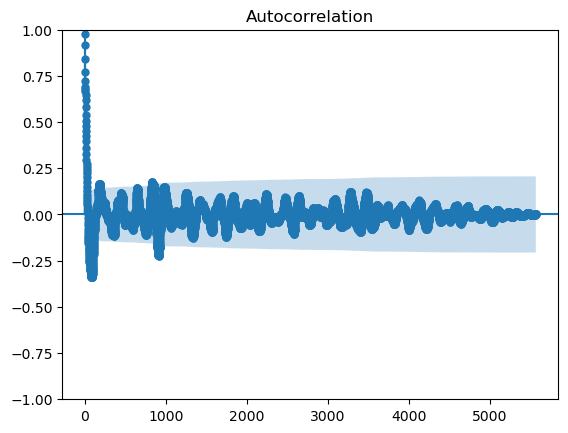

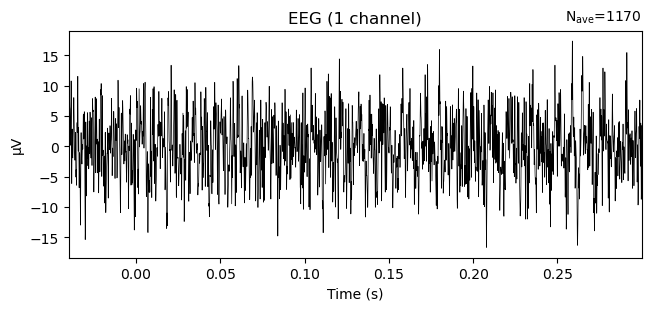

In [50]:
stim_epochs.average().plot();

In [51]:
stim_data = stim_epochs.average().get_data()[0,:]
active_data = task_evoked_dict['active'].get_data()[0,:]
passive_data = task_evoked_dict['passive'].get_data()[0,:]

In [78]:
np.array(range(len(stim_data)))

array([   0,    1,    2, ..., 5568, 5569, 5570])

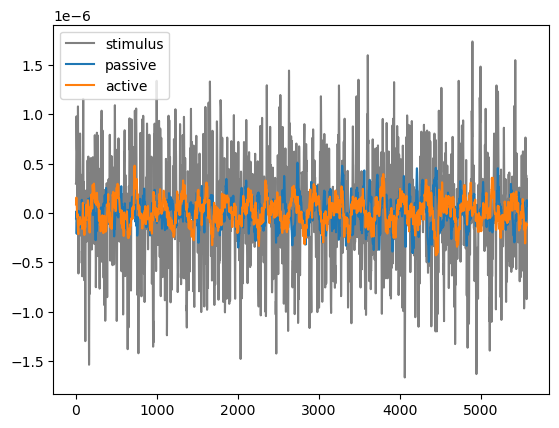

In [86]:
plt.plot(stim_data/10, color='grey')
plt.plot(passive_data)
plt.plot(active_data)
plt.legend(['stimulus','passive','active'])
#plt.xaxis(np.array(range(len(stim_data)))/16384)
plt.show()

In [52]:
from scipy.stats import spearmanr
active_res = spearmanr(active_data, stim_data, alternative='greater')
passive_res = spearmanr(passive_data, stim_data, alternative='greater')


In [53]:
active_res

SignificanceResult(statistic=0.013488523482214512, pvalue=0.15706554806619186)

In [54]:
passive_res

SignificanceResult(statistic=-0.0022353155565718644, pvalue=0.5662381718955769)